## Opensoundscape API

Please give a short description of your model here and the benefit it provides.  Also, don't forget to mention your organization here so the world can know that this is your amazing work!

This template will load an image, show it, and call a fake API unrelated to that image.  We're guessing your API will do more interesting things.

### Imports and constants

In [1]:
import io
import json
import requests
 
%autosave 0

# WILL NEED TO GET UPDATED 
API_URL = "http://localhost:8081/v1/birds"

# WILL NEED TO GET UPDATED
WAV_URL = "./client/soundscape.wav"#"./219348-split-4_onechannel.wav"

Autosave disabled


### Functions

In [2]:
def translate_names(name, from_col='scientific', to_col='bn_common'):
    '''
    Translate between two columns of translation df
    '''
    
    rows = pd.read_csv('species_table.csv', usecols=[from_col, to_col])
    return rows[rows[from_col] == name].iloc[0][to_col]

In [3]:
def get_audio():  
#     image_data = requests.get(WAV_URL) 
#     return image_data.content
    with open(WAV_URL, "rb") as audio:
        return audio.read()

def predict(data):
    try:           
        r = requests.post(f"{API_URL}/detect", data=data)

        if r.ok:
            return r.json()
        else:
            return None

    except Exception as e:
        print('Exception running API: {}'.format(e))
        
def show_spect(data): # data?
    try:
        r = requests.post(f"{API_URL}/spect", data=data) #can bytes be used as input to spect funcs?
        
        if r.ok:
            return r.json()
        else:
            return None
        
    except Exception as e:
        print('Exception running API: {}'.format(e))

### Retrieve and run prediction on audio

In [4]:
audio_bytes = get_audio()

In [5]:
image_dict = show_spect(audio_bytes)

### Call API and show results

In [6]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [7]:
# Get predictions
result = predict(audio_bytes)

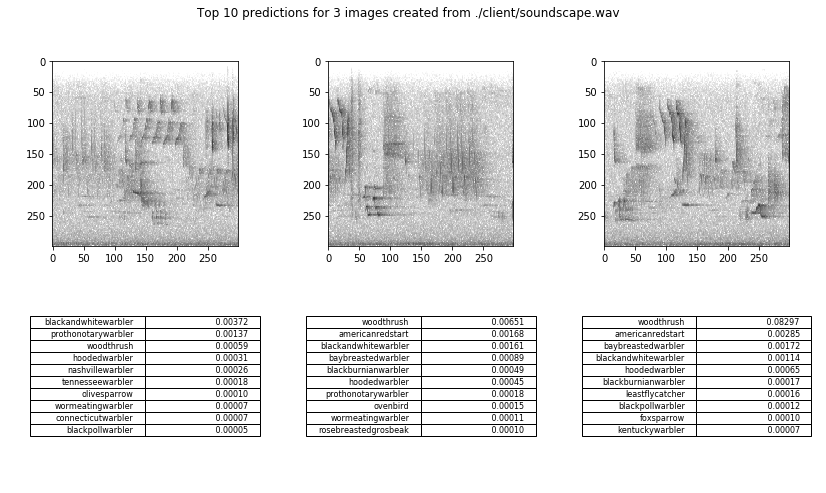

In [8]:
num_preds_to_show = 10
num_imgs = len(image_dict['images'])
(rows, cols) = (2, num_imgs)
fig, axs = plt.subplots(rows, cols, figsize=(rows*7, cols*(num_preds_to_show/4)))
img_axs = axs[0]
result_axs = axs[1]
plt.suptitle(f'Top {num_preds_to_show} predictions for {num_imgs} images created from {WAV_URL}')

for img_idx, preds in enumerate(result['predictions']):
    
    ## Plot image
    image = image_dict['images'][img_idx]
    pil_img = Image.fromarray(((np.array(image))).astype(np.uint8))
    img_axs[img_idx].imshow(pil_img)
    
    # Plot predictions as a table
    # Create blank dataframe
    preds_df = pd.DataFrame(columns = ['scientific-name', 'common-name', 'prediction'])

    # Split predictions list into scientific and prediction name columns
    preds_df[['scientific-name', 'prediction']] = pd.DataFrame(preds)[0].str.split(':', expand=True)

    # Sort values and subset to top 20
    preds_df = preds_df.sort_values(by = 'prediction', ascending = False).iloc[:num_preds_to_show]

    # Translate from scientific to common names
    preds_df['common-name'] = preds_df['scientific-name'].apply(translate_names)
    preds_df.index = range(1, len(preds_df)+1)
    
    table = result_axs[img_idx].table(
        cellText=preds_df.drop('scientific-name', axis=1).values.tolist(),
        loc='center',
    )
    #the_table.auto_set_font_size(False)
    table.set_fontsize(20)
    result_axs[img_idx].axis("off")
#fig.tight_layout()
plt.show()